In [1083]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score, r2_score , confusion_matrix, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys, operator
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

from IPython.display import display

In [6]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [835]:
flip_sign_dict = {
    '<': '>=',
    '>': '<=',
    '=': '!=',
    '>=': '<',
    '<=': '>',
    '!=': '=='
}

'''
    input: rule (str)
'''
def flip_rule(rule):
    rule = re.sub(r'\b=\b',' = ',rule) # for LIME
#     rule = rule.replace('&','and') # for RuleFit
    found_rule = re.findall('.* <=? [a-zA-Z]+ <=? .*', rule) # for LIME
    ret = ''
    
    # for LIME that has condition like this: 0.53 < nref <= 0.83
    if len(found_rule) > 0:
        found_rule = found_rule[0]
    
        var_in_rule = re.findall('[a-zA-Z]+',found_rule)

        var_in_rule = var_in_rule[0]
        
        splitted_rule = found_rule.split(var_in_rule)
        splitted_rule[0] = splitted_rule[0] + var_in_rule # for left side
        splitted_rule[1] = var_in_rule + splitted_rule[1] # for right side
        combined_rule = splitted_rule[0] + ' or ' + splitted_rule[1]
        ret = flip_rule(combined_rule)
        
    else:
        for tok in rule.split():
            if tok in flip_sign_dict:
                ret = ret + flip_sign_dict[tok] + ' '
            else:
                ret = ret + tok + ' '
    return ret

def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def sort_global_feature(global_model, indep):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    sorted_global_features = list(global_feature_df['feature'])

    return sorted_global_features

def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
#     print(rule_df)
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)
#     top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("coef", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def get_rule_str_of_rulefit_new_version(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    rule_df =  rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False)
    
    rule_list = list(rule_df['rule'])
    dup_feature_in_rule = [] # true or false...
    
    for r in rule_list:
        var_in_rule = re.findall('[a-zA-Z]+', r)
        var_count = Counter(var_in_rule)
        max_count = max(list(var_count.values()))
        
        if max_count > 1:
            dup_feature_in_rule.append(True)
        else:
            dup_feature_in_rule.append(False)
           
    if False not in set(dup_feature_in_rule):
#         print('wtf')
        rule_df = rule_df.head(5)
        the_best_defective_rule_str = list(rule_df['rule'])[0]
        
    else:
        rule_df['contain_dup_var'] = dup_feature_in_rule    
        the_best_defective_rule_str = rule_df[rule_df['contain_dup_var']==False].iloc[0]['rule']
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [901]:
def test_new_rule_from_rulefit(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    c = 0
    
#     py_exp_all_rules = []
#     lime_all_rules = []
    py_exp_all_vars = []
    lime_all_vars = []
    
    print('global feature feature importance ranking:')
    print(sort_global_feature(global_model, indep))
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        py_exp_local_model = py_exp['local_model']
        
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))
        
#         py_exp_rule = get_rule_str_of_rulefit(py_exp_local_model)
        py_exp_rule_new = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_rule_new, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred == 1:
            py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_rule_new)))
            py_exp_all_vars.extend(py_exp_var_in_rule)
        if lime_pred == 1:
            lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))
            lime_all_vars.extend(lime_var_in_rule)
            
#         py_exp_all_rules.append(py_exp_rule_new)
#         lime_all_rules.append(lime_the_best_defective_rule_str)
        
#         eval_result = eval_rule(lime_the_best_defective_rule_str, X_explain)

#         if eval_result[0]:
#             c =c+1

    
#     print(len(set(py_exp_all_rules)))
#     print(len(set(lime_all_rules)))
    
    print('pyExplainer var count')
    print(Counter(py_exp_all_vars))
    print('-'*100)
    print('LIME var count')
    print(Counter(lime_all_vars))
    
print('openstack')
test_new_rule_from_rulefit('openstack')
print('*'*100)
print('qt')
test_new_rule_from_rulefit('qt')

openstack
global feature feature importance ranking:
['ent', 'nrev', 'la', 'app', 'rtime', 'rrexp', 'age', 'asawr', 'rsawr', 'ndev', 'nd', 'ns', 'self']
pyExplainer var count
Counter({'la': 111, 'ent': 78, 'nrev': 67, 'asawr': 41, 'app': 35, 'age': 26, 'rsawr': 10, 'ns': 7, 'rrexp': 6, 'ndev': 4, 'nd': 2, 'rtime': 2})
----------------------------------------------------------------------------------------------------
LIME var count
Counter({'la': 152, 'ent': 35, 'nrev': 8, 'ns': 3})
****************************************************************************************************
qt
global feature feature importance ranking:
['nrev', 'ent', 'la', 'ndev', 'hcmt', 'app', 'age', 'rtime', 'ld', 'rsexp', 'asawr', 'asexp', 'rsawr', 'ns', 'nd', 'self']
pyExplainer var count
Counter({'ent': 29, 'la': 28, 'asexp': 17, 'age': 14, 'asawr': 9, 'nrev': 6, 'ns': 4, 'rtime': 4, 'app': 2, 'ld': 1, 'ndev': 1})
-------------------------------------------------------------------------------------------

In [ ]:
def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
    return list(found_features)

# def eval_rule(rule, X_explain):
#     var_in_rule = re.findall('[a-zA-Z]+',rule)
#     rule = rule.replace('&','and') # just for rulefit
#     rule = re.sub(r'\b=\b','==',rule)
# #             rule = rule.replace('=','==')

#     var_dict = {}

#     for var in var_in_rule:
#         var_dict[var] = float(X_explain[var])

#     eval_result = eval(rule,var_dict)
#     return eval_result

        
def prepare_data_for_testing(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]
    
    return global_model, correctly_predict_df, indep, dep, feature_df
    
def rq1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)

        py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
        lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

        py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
        lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

        py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
        lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_dist_med, py_exp_def_pred_ratio])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                         lime_exp_dist_med, lime_exp_def_pred_ratio])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
    all_eval_result.columns =['project', 'commit id', 'method', 'euc_dist_med', 'defective_generated_instance_ratio']
    
#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ1_'+proj_name+'.csv',index=False)
    print('finished RQ1 of',proj_name)
    
    

In [ ]:
rq1_eval('openstack')
rq1_eval('qt')

,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,331.704115,0.431452
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,547.648247,0.050800
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,488.590016,0.689435
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1384.777800,0.049000
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,233.747669,0.463710


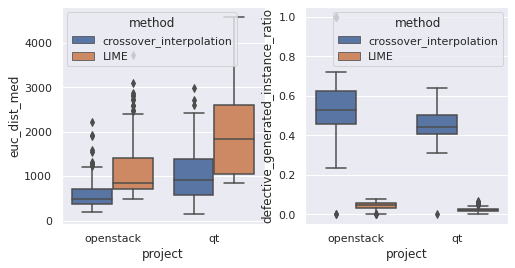

euc_dist_med                           \
                                         count         mean         std   
project   method                                                          
openstack LIME                           198.0  1126.993520  623.744796   
          crossover_interpolation        198.0   590.215781  337.090202   
qt        LIME                            79.0  1979.342782  993.311405   
          crossover_interpolation         79.0  1071.828395  660.068370   

                                                                         \
                                          min          25%          50%   
project   method                                                          
openstack LIME                     478.122694   707.911839   839.004043   
          crossover_interpolation  203.839673   363.359087   487.382627   
qt        LIME                     856.917999  1039.673910  1824.515489   
          crossover_interpolation  140.197536   583.644616   911.998473   

                                                             \
                                           75%          max   
project   method                                              
openstack LIME                     1406.863950  3714.300936   
          crossover_interpolation   705.485094  2222.543551   
qt        LIME                     2602.748286  4582.471964   
          crossover_interpolation  1376.061356  2974.539252   

                                  defective_generated_instance_ratio  \
                                                               count   
project   method                                                       
openstack LIME                                                 198.0   
          crossover_interpolation                              198.0   
qt        LIME                                                  79.0   
          crossover_interpolation                               79.0   

                                                                               \
                                       mean       std  min      25%       50%   
project   method                                                                
openstack LIME                     0.044074  0.017399  0.0  0.03355  0.050000   
          crossover_interpolation  0.544319  0.137944  0.0  0.45786  0.528195   
qt        LIME                     0.022592  0.013654  0.0  0.01600  0.023400   
          crossover_interpolation  0.452475  0.087663  0.0  0.40478  0.443548   

                                                       
                                        75%       max  
project   method                                       
openstack LIME                     0.055600  0.080200  
          crossover_interpolation  0.624881  1.000000  
qt        LIME                     0.027700  0.065400  
          crossover_interpolation  0.500436  0.639746

In [1043]:
openstack_result_df = pd.read_csv('./eval_result/RQ1_openstack.csv')
qt_result_df = pd.read_csv('./eval_result/RQ1_qt.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,2, figsize=(8,4))

sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method', ax=axs[0])
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method', ax=axs[1])
plt.show()

display(result_df.groupby(['project', 'method']).describe())

In [1037]:
def rq2_1_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    all_eval_result = pd.DataFrame()
    
    single_instance_pred_result = pd.DataFrame()
    
    ground_truth = np.ones(len(feature_df)).astype(bool)
#     print(ground_truth)

    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
        # this data can be used with local model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        py_exp_global_pred = global_model.predict(py_exp_synthetic_data) 
        py_exp_local_prob = py_exp_local_model.predict_proba(py_exp_synthetic_data)[:,1]
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
#         py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_prob)
        
        py_exp_auc = roc_auc_score(py_exp_global_pred, py_exp_local_prob)
        py_exp_f1 = f1_score(py_exp_global_pred, py_exp_local_pred)
        py_exp_mcc = matthews_corrcoef(py_exp_global_pred, py_exp_local_pred)
        py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
        
        lime_auc = roc_auc_score(lime_exp_global_pred, lime_exp_local_prob)
        lime_f1 = f1_score(lime_exp_global_pred, lime_exp_local_pred)
        lime_mcc = matthews_corrcoef(lime_exp_global_pred, lime_exp_local_pred)
        lime_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

        py_exp_serie = pd.Series(data=[proj_name, row_index, 'pyExplainer',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)
        
###         predict single instance (only predict X_explain)
        py_exp_single_local_prob = py_exp_local_model.predict_proba(X_explain.values)[:,1][0]
        py_exp_single_local_pred = py_exp_local_model.predict(X_explain.values)[0]
        
        
        selected_feature_indices = lime_exp['selected_feature_indeces']
        lime_feature = np.ones((1,len(selected_feature_indices)))
        lime_single_local_prob = lime_exp_local_model.predict(lime_feature)[0]
        lime_single_local_pred = bool(round(lime_exp_single_local_prob))
        
        single_instance_pred_result = single_instance_pred_result.append(pd.Series([row_index, py_exp_single_local_prob, 
                                                                                    py_exp_single_local_pred, lime_single_local_prob
                                                                                    lime_exp_single_local_pred]),
                                                                          ignore_index=True )
#         print(py_exp_single_local_prob, py_exp_single_local_pred, lime_exp_single_local_prob, lime_exp_single_local_pred)
        

        
#         break

    single_instance_pred_result.columns = ['commit id','py_exp_prob','py_exp_pred','lime_exp_pred','lime_pred']
    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
#     single_instance_pred_result.columns = ['commit_id','pyExplainer_pred', 'LIME_pred']
    
#     py_exp_f1 = f1_score(ground_truth, single_instance_pred_result['pyExplainer_pred'])
#     py_exp_mcc = matthews_corrcoef(ground_truth, single_instance_pred_result['pyExplainer_pred'])
#     py_exp_bal_acc = balanced_accuracy_score(ground_truth, single_instance_pred_result['pyExplainer_pred'])
    
#     lime_exp_f1 = f1_score(ground_truth, single_instance_pred_result['LIME_pred'])
#     lime_exp_mcc = matthews_corrcoef(ground_truth, single_instance_pred_result['LIME_pred'])
#     lime_exp_bal_acc = balanced_accuracy_score(ground_truth, single_instance_pred_result['LIME_pred'])
    
#     print(py_exp_f1, py_exp_bal_acc)
#     print(lime_exp_f1, lime_exp_bal_acc)
    
#     print(np.sum(single_instance_pred_result['pyExplainer_pred']))
#     print(np.sum(single_instance_pred_result['LIME_pred']))
    
#     display(single_instance_pred_result)
#     display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ2_'+proj_name+'_global_vs_local_synt_pred.csv',index=False)
    print('finished RQ2 of',proj_name)

In [1038]:
rq2_1_eval('openstack')
rq2_1_eval('qt')

/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

finished RQ2 of openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


finished RQ2 of qt


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,pyExplainer,0.914181,0.971497,0.905936,0.832332
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.579753,0.740423,0.281192,0.268961
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,pyExplainer,1.000000,1.000000,1.000000,1.000000
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.580125,0.745687,0.282288,0.277408
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,pyExplainer,0.935895,0.986777,0.933446,0.874022


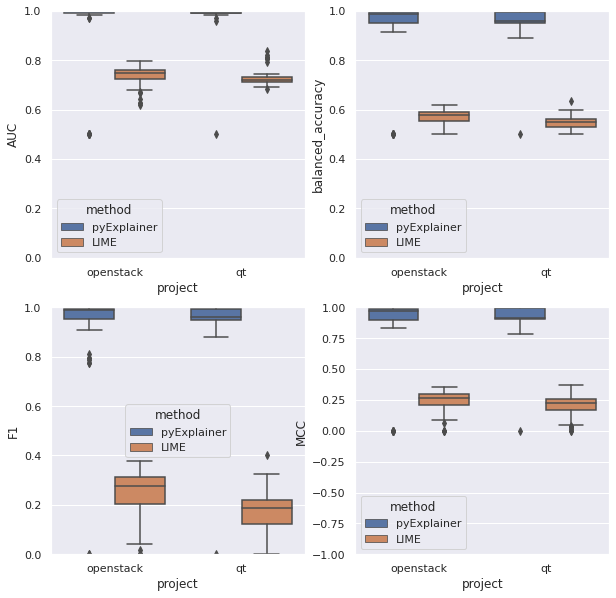

openstack result


balanced_accuracy                                               \
                        count      mean       std  min       25%       50%   
method                                                                       
LIME                    198.0  0.570394  0.027628  0.5  0.552933  0.578235   
pyExplainer             198.0  0.954411  0.096192  0.5  0.949023  0.985273   

                                   AUC                                \
                  75%       max  count      mean       std       min   
method                                                                 
LIME         0.591473  0.618989  198.0  0.739656  0.030157  0.620103   
pyExplainer  0.993522  1.000000  198.0  0.975125  0.097901  0.500000   

                                                        F1            \
                  25%       50%       75%       max  count      mean   
method                                                                 
LIME         0.723966  0.749075  0.759501  0.796816  198.0  0.248266   
pyExplainer  0.989653  0.999018  0.999794  1.000000  198.0  0.958855   

                                                                      MCC  \
                  std  min       25%       50%       75%       max  count   
method                                                                      
LIME         0.086481  0.0  0.202650  0.276290  0.311654  0.378698  198.0   
pyExplainer  0.105003  0.0  0.951318  0.987052  0.994695  1.000000  198.0   

                                                                              
                 mean       std  min       25%       50%       75%       max  
method                                                                        
LIME         0.248051  0.067190  0.0  0.211879  0.266913  0.296950  0.352627  
pyExplainer  0.910063  0.192529  0.0  0.899902  0.972633  0.987274  1.000000

qt result


balanced_accuracy                                               \
                        count      mean       std  min       25%       50%   
method                                                                       
LIME                     79.0  0.546394  0.026677  0.5  0.530102  0.549680   
pyExplainer              79.0  0.963060  0.058198  0.5  0.950907  0.957155   

                                  AUC                                          \
                  75%       max count      mean       std       min       25%   
method                                                                          
LIME         0.560867  0.633993  79.0  0.727975  0.030612  0.683462  0.712038   
pyExplainer  0.994771  1.000000  79.0  0.987565  0.055978  0.500000  0.990585   

                                            F1                           \
                  50%       75%      max count      mean       std  min   
method                                                                    
LIME         0.721298  0.729712  0.83789  79.0  0.169261  0.087309  0.0   
pyExplainer  0.992517  0.999792  1.00000  79.0  0.955015  0.111960  0.0   

                                                     MCC                      \
                  25%       50%       75%      max count      mean       std   
method                                                                         
LIME         0.120996  0.186503  0.220287  0.40197  79.0  0.200580  0.084425   
pyExplainer  0.946795  0.958858  0.994122  1.00000  79.0  0.927528  0.116113   

                                                        
             min       25%       50%       75%     max  
method                                                  
LIME         0.0  0.168595  0.228000  0.255264  0.3734  
pyExplainer  0.0  0.905929  0.916379  0.990005  1.0000

In [1039]:
openstack_result_df = pd.read_csv('./eval_result/RQ2_openstack_global_vs_local_synt_pred.csv')
qt_result_df = pd.read_csv('./eval_result/RQ2_qt_global_vs_local_synt_pred.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set_ylim([0, 1])
axs[0,1].set_ylim([0, 1]) 
axs[1,0].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

plt.ylim(-1,1)
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

pd.set_option("max_columns", 40)
print('openstack result')
display(openstack_result_df.groupby('method').describe())
print('qt result')
display(qt_result_df.groupby('method').describe())

In [1074]:
def eval_rule(rule, x_df):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    
    eval_result_list = []
    
#     print(rule)

    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            var_dict[var] = float(x[var])

#         print(var_dict)
        
        # if the rule does not satisfy clean commit, the truth value of the inversed rule when applied to clean commit is true
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)
        
#         print(eval_result)
#         break
        
    return eval_result_list

# def summarize_rule_eval_result(py_exp_rule_str, lime_rule_str, x_df, ground_truth):
# #     print('Rulefit')
#     py_exp_all_eval_result = eval_rule(py_exp_rule_str, x_df)
# #     print('LIME')
#     lime_all_eval_result = eval_rule(lime_rule_str, x_df)

# #     print(py_exp_rule_str)
# #     print(lime_rule_str)
    
# #     tmp_df = x_df.copy()
# #     tmp_df['ground_truth'] = ground_truth
# #     tmp_df_clean = tmp_df[tmp_df['ground_truth']==False]
    
# #     display(tmp_df_clean)
    
#     py_exp_result_df = pd.DataFrame()
#     py_exp_result_df['ground_truth'] = ground_truth
#     py_exp_result_df['rule_result'] = py_exp_all_eval_result
#     py_exp_result_df = py_exp_result_df[py_exp_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print('py_exp_result_df')
# #     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
# #     print(len(py_exp_result_df))
#     # find ratio of clean commit
#     py_exp_satisfy_rule_ratio = 100*(len(py_exp_result_df[py_exp_result_df['ground_truth']==False])/len(py_exp_result_df)) if len(py_exp_result_df) > 0 else 0
    
#     lime_result_df = pd.DataFrame()
#     lime_result_df['ground_truth'] = ground_truth
#     lime_result_df['rule_result'] = lime_all_eval_result
    
#     lime_result_df = lime_result_df[lime_result_df['rule_result']==True] # get commit that matches counter rule
    
# #     print(len(lime_result_df))
    
#     # find ratio of clean commit
# #     print('lime_result_df')
# #     display(lime_result_df[lime_result_df['ground_truth']==False])
#     lime_satisfy_rule_ratio = 100*(len(lime_result_df[lime_result_df['ground_truth']==False])/len(lime_result_df))  if len(lime_result_df) > 0 else 0
    
# #     print(len(py_exp_result_df[py_exp_result_df['ground_truth']==False]))
# #     print(len(lime_result_df[lime_result_df['ground_truth']==False]))
    
#     return py_exp_satisfy_rule_ratio, lime_satisfy_rule_ratio

def summarize_rule_eval_result(rule_str, x_df):
#     print('Rulefit')
    all_eval_result = eval_rule(rule_str, x_df)
    all_eval_result = np.array(all_eval_result).astype(bool)
    
#     result_df = pd.DataFrame()
#     result_df['ground_truth'] = ground_truth
#     result_df['rule_result'] = all_eval_result
#     result_df = result_df[result_df['rule_result']==True] # get commit that matches counter rule
    
#     print('py_exp_result_df')
#     display(py_exp_result_df[py_exp_result_df['ground_truth']==False])
#     print(len(py_exp_result_df))
    # find ratio of clean commit
#     satisfy_rule_ratio = 100*(len(result_df[result_df['ground_truth']==False])/len(result_df)) if len(result_df) > 0 else 0

    return all_eval_result

In [1132]:
def test_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data

    py_exp_guide = []
    lime_guide = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
        total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
            py_exp_guide.append(py_exp_the_best_defective_rule_str)

        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
            lime_guide.append(lime_the_best_defective_rule_str)
        
    print(set(py_exp_guide))
    print('total guidance:',len(set(py_exp_guide)))
    print('-'*100)
    print(set(lime_guide))
    print('total guidance:',len(set(lime_guide)))

In [1133]:
test_rule('openstack')

{'asawr <= 0.004999999888241291 & nrev <= 1.0099999904632568 & nd > 3.6750000715255737 ', 'nrev <= 1.0049999952316284 & ent > 0.8550000190734863 & ent <= 0.004999999888241291 ', 'rsawr <= 0.8449999988079071 & app > 3.9700000286102295 ', 'nrev <= 2.9800000190734863 & nrev <= 3.0549999475479126 ', 'rtime > 92.92500305175781 & ndev > 68.63000106811523 & age > 2.8399999141693115 ', 'nrev <= 2.634999990463257 & ndev > 20.90499973297119 & ndev <= -2.4200000166893005 ', 'rsawr > 0.35500000417232513 & ndev > 177.24500274658203 & rtime <= 2.3899999856948853 ', 'asawr <= 0.004999999888241291 & age <= 0.8400000035762787 & asawr > 0.0950000025331974 ', 'nrev <= 3.034999966621399 & nrev <= 2.975000023841858 & ent > 0.9750000238418579 ', 'app <= 2.009999990463257 & ent > 0.8650000095367432 ', 'rsawr <= 0.7549999952316284 ', 'nrev > 6.8450000286102295 & age <= 0.12999999895691872 & rrexp <= 474.5299987792969 ', 'rrexp <= 616.5599975585938 & nrev <= 3.0399999618530273 ', 'asawr > 0.13499999791383743 &

In [1134]:
test_rule('qt')

{'age <= 0.06500000134110451 & nrev <= 2.0049999952316284 & app <= 2.069999933242798 ', 'rtime <= 8.12999963760376 & ndev <= 0.08999998867511749 & hcmt <= 16.255000114440918 ', 'rsexp <= 498.81500244140625 & asawr <= 0.004999999888241291 & nd > 11.925000190734863 ', 'rsexp <= 1730.5299682617188 ', 'hcmt <= 4.134999990463257 & la <= 48.989999771118164 & age > 25.104999542236328 ', 'nrev <= 3.0899999141693115 & nrev <= 2.890000104904175 ', 'nrev <= 3.2549999952316284 & nrev <= 2.9850000143051147 ', 'asawr > 0.03499999921768904 & ndev > 4.78000020980835 ', 'rsexp <= 1662.114990234375 & ent <= 0.004999999888241291 & ld > 242.52999877929688 ', 'ndev <= 12.980000019073486 & nrev <= 0.8500000238418579 ', 'ent > 0.9549999833106995 & asawr <= 0.044999999925494194 & nrev <= 1.0149999856948853 ', 'nrev <= 1.7900000214576721 & nrev <= 3.0049999952316284 & ent <= 0.004999999888241291 ', 'ld <= 4.865000009536743 & la <= -613.0149841308594 & ld > 101.69500350952148 ', 'nrev <= 10.539999961853027 & nd

In [1116]:
## use inverse rule to predict train/test clean instance
def rq3_eval(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    rq3_eval_result = pd.DataFrame() # for train data
#     rq4_eval_result = pd.DataFrame() # for test data
    
#     display(x_test)
    
    c = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
#         print(py_exp_the_best_defective_rule_str)
        
        total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
        
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
#         print(lime_the_best_defective_rule_str)
#         lime_exp_condition_list = lime_exp['rule'].as_list()
        
#         lime_exp_condition_list.sort(key=operator.itemgetter(1), reverse=True)

#         top_k_lime_condition = [lime_exp_condition_list[i][0] for i in range(0,total_cond_in_py_exp)]

#         reverse_top_k_lime_cond = [flip_rule(cond).strip() for cond in top_k_lime_condition]
#         reverse_top_k_lime_cond = ['('+cond+')' if 'or' in cond else cond for cond in reverse_top_k_lime_cond]
# #         print(reverse_top_k_lime_cond)

#         lime_the_best_defective_rule_str = ' & '.join(reverse_top_k_lime_cond)
        
#         print(lime_the_best_defective_rule_str)
        
#         print('-'*100)
#         break
#         lime_exp_the_best_defective_rule_str = flip_rule(lime_exp_the_best_defective_rule_str)

        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        if py_exp_pred:
            py_exp_the_best_defective_rule_str = flip_rule(py_exp_the_best_defective_rule_str)
#             py_exp_satisfy_rule_ratio_train = summarize_rule_eval_result(py_exp_the_best_defective_rule_str,
#                                                                                 x_train, y_train)
            py_exp_rule_eval = summarize_rule_eval_result(py_exp_the_best_defective_rule_str, x_test)
#             display(py_exp_rule_eval_df)
            tn, fp, fn, tp = confusion_matrix(y_test, py_exp_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, py_exp_rule_eval, labels=[1,0])
            rec = recall_score(y_test, py_exp_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, py_exp_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, py_exp_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
#             py_exp_serie_train = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_satisfy_rule_ratio_train])
            py_exp_serie_test = pd.Series(data=[proj_name, row_index, 'pyExplainer',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(py_exp_serie_test,ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(py_exp_serie_test,ignore_index=True)
        
        if lime_pred:
            lime_the_best_defective_rule_str = flip_rule(lime_the_best_defective_rule_str)
#             lime_satisfy_rule_ratio_train = summarize_rule_eval_result(lime_the_best_defective_rule_str,
#                                                                                     x_train, y_train)
            lime_rule_eval = summarize_rule_eval_result(lime_the_best_defective_rule_str, x_test)
            tn, fp, fn, tp = confusion_matrix(y_test, lime_rule_eval, labels=[1,0]).ravel()
            tp_rate = tp/(tp+fn)
            tn_rate = tn/(tn+fp)
            
            prec = precision_score(y_test, lime_rule_eval, labels=[1,0])
            rec = recall_score(y_test, lime_rule_eval, labels=[1,0])
            f1 = f1_score(y_test, lime_rule_eval, labels=[1,0])
            bal_acc = balanced_accuracy_score(y_test, lime_rule_eval)
            
#             print(tn,fp,fn,tp, tn_rate, tp_rate)
            lime_serie_test = pd.Series(data=[proj_name, row_index, 'LIME',tn,fp,fn,tp,tp_rate,tn_rate, prec, rec, f1, bal_acc])
        
            rq3_eval_result = rq3_eval_result.append(lime_serie_test, ignore_index=True)
#             rq4_eval_result = rq4_eval_result.append(lime_exp_serie_test, ignore_index=True)
        
#         if lime_pred and py_exp_pred:
#             break
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
#         break
        
    rq3_eval_result.columns = ['project', 'commit id', 'method', 'true_negative',
                               'false_positive','false_nagative','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate',
                               'precision','recall','f1','balance_accuracy']
    
    rq3_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'.csv',index=False)
    print('finished RQ3 of',proj_name)
    
    

In [1117]:
start = time.time()
print('openstack')
rq3_eval('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
rq3_eval('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 34 from 198 commits
finished 35 from 198 commits
finished 36 from 198 commits
finished 37 from 198 commits
finished 38 from 198 commits
finished 39 from 198 commits
finished 40 from 198 commits
finished 41 from 198 commits
finished 42 from 198 commits
finished 43 from 198 commits
finished 44 from 198 commits
finished 45 from 198 commits
finished 46 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 47 from 198 commits
finished 48 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 49 from 198 commits
finished 50 from 198 commits
finished 51 from 198 commits
finished 52 from 198 commits
finished 53 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 54 from 198 commits
finished 55 from 198 commits
finished 56 from 198 commits
finished 57 from 198 commits
finished 58 from 198 commits
finished 59 from 198 commits
finished 60 from 198 commits
finished 61 from 198 commits
finished 62 from 198 commits
finished 63 from 198 commits
finished 64 from 198 commits
finished 65 from 198 commits
finished 66 from 198 commits
finished 67 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 68 from 198 commits
finished 69 from 198 commits
finished 70 from 198 commits
finished 71 from 198 commits
finished 72 from 198 commits
finished 73 from 198 commits
finished 74 from 198 commits
finished 75 from 198 commits
finished 76 from 198 commits
finished 77 from 198 commits
finished 78 from 198 commits
finished 79 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 80 from 198 commits
finished 81 from 198 commits
finished 82 from 198 commits
finished 83 from 198 commits
finished 84 from 198 commits
finished 85 from 198 commits
finished 86 from 198 commits
finished 87 from 198 commits
finished 88 from 198 commits
finished 89 from 198 commits
finished 90 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 91 from 198 commits
finished 92 from 198 commits
finished 93 from 198 commits
finished 94 from 198 commits
finished 95 from 198 commits
finished 96 from 198 commits
finished 97 from 198 commits
finished 98 from 198 commits
finished 99 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 100 from 198 commits
finished 101 from 198 commits
finished 102 from 198 commits
finished 103 from 198 commits
finished 104 from 198 commits
finished 105 from 198 commits
finished 106 from 198 commits
finished 107 from 198 commits
finished 108 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 109 from 198 commits
finished 110 from 198 commits
finished 111 from 198 commits
finished 112 from 198 commits
finished 113 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 114 from 198 commits
finished 115 from 198 commits
finished 116 from 198 commits
finished 117 from 198 commits
finished 118 from 198 commits
finished 119 from 198 commits
finished 120 from 198 commits
finished 121 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 122 from 198 commits
finished 123 from 198 commits
finished 124 from 198 commits
finished 125 from 198 commits
finished 126 from 198 commits
finished 127 from 198 commits
finished 128 from 198 commits
finished 129 from 198 commits
finished 130 from 198 commits
finished 131 from 198 commits
finished 132 from 198 commits
finished 133 from 198 commits
finished 134 from 198 commits
finished 135 from 198 commits
finished 136 from 198 commits
finished 137 from 198 commits
finished 138 from 198 commits
finished 139 from 198 commits
finished 140 from 198 commits
finished 141 from 198 commits
finished 142 from 198 commits
finished 143 from 198 commits
finished 144 from 198 commits
finished 145 from 198 commits
finished 146 from 198 commits
finished 147 from 198 commits
finished 148 from 198 commits
finished 149 from 198 commits
finished 150 from 198 commits
finished 151 from 198 commits
finished 152 from 198 commits
finished 153 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 154 from 198 commits
finished 155 from 198 commits
finished 156 from 198 commits
finished 157 from 198 commits
finished 158 from 198 commits
finished 159 from 198 commits
finished 160 from 198 commits
finished 161 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 162 from 198 commits
finished 163 from 198 commits
finished 164 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 165 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 166 from 198 commits
finished 167 from 198 commits
finished 168 from 198 commits
finished 169 from 198 commits
finished 170 from 198 commits
finished 171 from 198 commits
finished 172 from 198 commits
finished 173 from 198 commits
finished 174 from 198 commits
finished 175 from 198 commits
finished 176 from 198 commits
finished 177 from 198 commits
finished 178 from 198 commits
finished 179 from 198 commits
finished 180 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 181 from 198 commits
finished 182 from 198 commits
finished 183 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 184 from 198 commits
finished 185 from 198 commits
finished 186 from 198 commits
finished 187 from 198 commits
finished 188 from 198 commits
finished 189 from 198 commits
finished 190 from 198 commits
finished 191 from 198 commits
finished 192 from 198 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 193 from 198 commits
finished 194 from 198 commits
finished 195 from 198 commits
finished 196 from 198 commits
finished 197 from 198 commits
finished 198 from 198 commits
finished RQ3 of openstack
finished in 191.43253469467163 secs
qt
finished 1 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 2 from 79 commits
finished 3 from 79 commits
finished 4 from 79 commits
finished 5 from 79 commits
finished 6 from 79 commits
finished 7 from 79 commits
finished 8 from 79 commits
finished 9 from 79 commits
finished 10 from 79 commits
finished 11 from 79 commits
finished 12 from 79 commits
finished 13 from 79 commits
finished 14 from 79 commits
finished 15 from 79 commits
finished 16 from 79 commits
finished 17 from 79 commits
finished 18 from 79 commits
finished 19 from 79 commits
finished 20 from 79 commits
finished 21 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 22 from 79 commits
finished 23 from 79 commits
finished 24 from 79 commits
finished 25 from 79 commits
finished 26 from 79 commits
finished 27 from 79 commits
finished 28 from 79 commits
finished 29 from 79 commits
finished 30 from 79 commits
finished 31 from 79 commits
finished 32 from 79 commits
finished 33 from 79 commits
finished 34 from 79 commits
finished 35 from 79 commits
finished 36 from 79 commits
finished 37 from 79 commits
finished 38 from 79 commits
finished 39 from 79 commits
finished 40 from 79 commits
finished 41 from 79 commits
finished 42 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 43 from 79 commits
finished 44 from 79 commits
finished 45 from 79 commits
finished 46 from 79 commits
finished 47 from 79 commits
finished 48 from 79 commits
finished 49 from 79 commits
finished 50 from 79 commits
finished 51 from 79 commits
finished 52 from 79 commits
finished 53 from 79 commits
finished 54 from 79 commits
finished 55 from 79 commits
finished 56 from 79 commits


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


finished 57 from 79 commits
finished 58 from 79 commits
finished 59 from 79 commits
finished 60 from 79 commits
finished 61 from 79 commits
finished 62 from 79 commits
finished 63 from 79 commits
finished 64 from 79 commits
finished 65 from 79 commits
finished 66 from 79 commits
finished 67 from 79 commits
finished 68 from 79 commits
finished 69 from 79 commits
finished 70 from 79 commits
finished 71 from 79 commits
finished 72 from 79 commits
finished 73 from 79 commits
finished 74 from 79 commits
finished 75 from 79 commits
finished 76 from 79 commits
finished 77 from 79 commits
finished 78 from 79 commits
finished 79 from 79 commits
finished RQ3 of qt
finished in 95.8318121433258 secs


true_negative                                        \
                              count        mean         std    min    25%   
project   method                                                            
openstack LIME                198.0  310.353535   72.296178   20.0  297.0   
          pyExplainer         100.0   68.680000  110.351494    0.0    0.0   
qt        LIME                 47.0  254.340426   85.949752  208.0  208.0   
          pyExplainer          27.0   74.185185   97.126419    0.0    2.0   

                                           false_positive              \
                         50%    75%    max          count        mean   
project   method                                                        
openstack LIME         297.0  297.0  617.0          198.0  335.646465   
          pyExplainer   13.0   87.5  483.0          100.0  577.320000   
qt        LIME         208.0  208.0  454.0           47.0  221.659574   
          pyExplainer   32.0  103.0  317.0           27.0  401.814815   

                                                                      \
                              std    min    25%    50%    75%    max   
project   method                                                       
openstack LIME          72.296178   29.0  349.0  349.0  349.0  626.0   
          pyExplainer  110.351494  163.0  558.5  633.0  646.0  646.0   
qt        LIME          85.949752   22.0  268.0  268.0  268.0  268.0   
          pyExplainer   97.126419  159.0  373.0  444.0  474.0  476.0   

                      false_nagative                                    ...  \
                               count         mean          std     min  ...   
project   method                                                        ...   
openstack LIME                 198.0  2690.171717   364.677691   202.0  ...   
          pyExplainer          100.0   479.010000   678.762458     0.0  ...   
qt        LIME                  47.0  6123.936170   555.954229  5185.0  ...   
          pyExplainer           27.0  1818.185185  2117.607050     0.0  ...   

                         recall                                   f1  \
                            25%       50%       75%       max  count   
project   method                                                       
openstack LIME         0.459752  0.459752  0.459752  0.955108  198.0   
          pyExplainer  0.000000  0.020124  0.135449  0.747678  100.0   
qt        LIME         0.436975  0.436975  0.436975  0.953782   47.0   
          pyExplainer  0.004202  0.067227  0.216387  0.665966   27.0   

                                                                         \
                           mean       std       min       25%       50%   
project   method                                                          
openstack LIME         0.167882  0.032675  0.046083  0.161063  0.161063   
          pyExplainer  0.070107  0.079253  0.000000  0.000000  0.033039   
qt        LIME         0.074843  0.026897  0.060377  0.060377  0.060377   
          pyExplainer  0.040812  0.036153  0.000000  0.005101  0.041150   

                                          balance_accuracy            \
                            75%       max            count      mean   
project   method                                                       
openstack LIME         0.161063  0.350568            198.0  0.334699   
          pyExplainer  0.120830  0.259875            100.0  0.480953   
qt        LIME         0.060377  0.128286             47.0  0.374655   
          pyExplainer  0.069595  0.112288             27.0  0.461390   

                                                                         \
                            std       min       25%       50%       75%   
project   method                                                          
openstack LIME         0.050193  0.316099  0.316099  0.316099  0.316099   
          pyExplainer  0.036037  0.356645  0.471446  0.498475  0.500000   


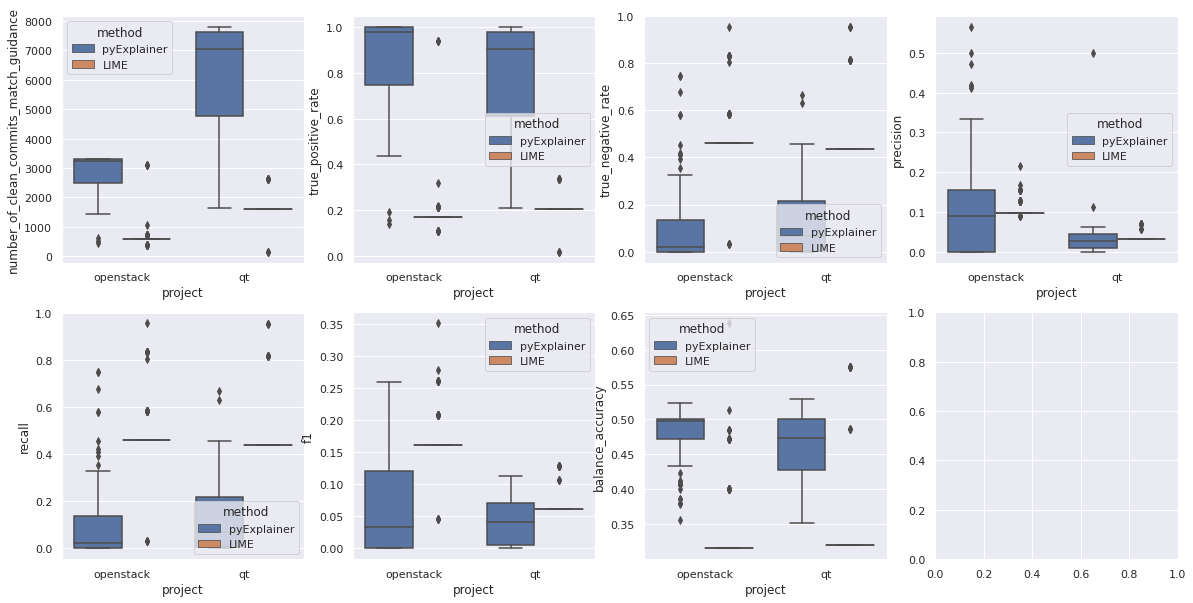

In [1122]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack.csv')
# openstack_result_df.columns = ['project', 'commit id', 'method', 'true_negative',
#                                'false_positive','false_nagative','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate',
#                                'precision','recall','f1','balance_accuracy']
# openstack_result_df.to_csv('./eval_result/RQ3_openstack.csv',index=False)

qt_result_df = pd.read_csv('./eval_result/RQ3_qt.csv')
# qt_result_df.columns = ['project', 'commit id', 'method', 'true_negative',
#                                'false_positive','false_nagative','number_of_clean_commits_match_guidance', 'true_positive_rate','true_negative_rate',
#                                'precision','recall','f1','balance_accuracy']
# qt_result_df.to_csv('./eval_result/RQ3_qt.csv',index=False)

fig, axs = plt.subplots(2,4, figsize=(20,10))
result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head(10))

# plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='number_of_clean_commits_match_guidance', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='true_positive_rate', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='true_negative_rate', hue='method', ax=axs[0,2])
sns.boxplot(data=result_df, x='project', y='precision', hue='method', ax=axs[0,3])
sns.boxplot(data=result_df, x='project', y='recall', hue='method', ax=axs[1,0])
sns.boxplot(data=result_df, x='project', y='f1', hue='method', ax=axs[1,1])
sns.boxplot(data=result_df, x='project', y='balance_accuracy', hue='method', ax=axs[1,2])

display(result_df.groupby(['project','method']).describe())

In [1135]:
print(set(openstack_result_df[openstack_result_df['method']=='LIME']['number_of_clean_commits_match_guidance']))

{2616.0, 1595.0, 158.0}


In [949]:
'''
    Exclusiveness ({rule}->Defect) = lift({rule} -> Defect) / (lift({rule} -> Defect) + lift({rule} -> Clean))

    p = rule (which instances match rules)
    q = Defect/Clean
    lift(p -> q) = support(p -> q)/(support(p)*support(q))
'''


'''
    instance_df: a dataframe of generated instances or test instances
'''
def cal_exculsiveness(rule, instance_df, label):
    
    def cal_lift(support_p_q, support_p, support_q):
        lift = support_p_q/(support_p*support_q) if support_p > 0 and support_q > 0 else 0
        return lift

    label = np.array(label)
    rule_result = eval_rule(rule, instance_df)
    rule_result = np.array(rule_result)
    all_row = len(rule_result)
#     print(rule_result)
    support_p = np.sum(rule_result)/all_row
    
    support_defect = np.sum(label)/all_row
    support_clean = np.sum(label==False)/all_row
    
    support_p_defect = np.sum((rule_result==True)&(label==True))/all_row
    support_p_clean = np.sum((rule_result==True)&(label==False))/all_row
    
    lift_defect = cal_lift(support_p_defect, support_p, support_defect)
    lift_clean = cal_lift(support_p_clean, support_p, support_clean)
    
    exclusiveness = lift_defect/(lift_defect+lift_clean) if lift_defect+lift_clean > 0 else 0
    
#     print(support_p, support_defect, support_clean)
#     print(support_p_defect, support_p_clean)
#     print(lift_defect, lift_clean)
#     print('-'*100)
#     print(lift_defect, lift_clean, exclusiveness)
    return exclusiveness
#     test_df = pd.DataFrame()
#     test_df['rule_result'] = rule_result
#     test_df['label'] = label
    
# #     display(test_df)
#     display(test_df[(test_df['rule_result']==True) & (test_df['label']==True)])
#     display(test_df[(test_df['rule_result']==True) & (test_df['label']==False)])
    
#     print(support_p_defect, support_p_clean)
    
#     print(np.sum(label),all_row)
    
#     print((rule_result==True) and (label==True))
#     print(support_p,support_defect, support_clean)
    
def eval_exclusiveness(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_cols = x_train.columns
    
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_gen_inst =  py_exp['synthetic_data']
        py_exp_gen_pred = py_exp['synthetic_predictions']
        
        lime_gen_inst = lime_exp['synthetic_instance_for_global_model']
        lime_gen_inst_local = lime_exp['synthetic_instance_for_lobal_model']
        lime_gen_inst_pred = global_model.predict(lime_gen_inst)

        lime_selected_col = all_cols[selected_feature_indices]
        lime_gen_inst = lime_gen_inst[:,selected_feature_indices]  
        lime_gen_inst_local_df = pd.DataFrame(data=lime_gen_inst, columns=lime_selected_col)

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_excls_x_test = cal_exculsiveness(py_exp_the_best_defective_rule_str, x_test, y_test)
        
        lime_exp_excls_x_test = cal_exculsiveness(lime_the_best_defective_rule_str, x_test, y_test)
        
        py_exp_excls_gen_inst = cal_exculsiveness(py_exp_the_best_defective_rule_str, py_exp_gen_inst, 
                                                  py_exp_gen_pred)
        lime_exp_excls_gen_inst = cal_exculsiveness(lime_the_best_defective_rule_str, lime_gen_inst_local_df, 
                                                    lime_gen_inst_pred)
        
        py_exp_excls_serie =  pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                              py_exp_excls_x_test, py_exp_excls_gen_inst])
        lime_excls_serie =  pd.Series(data=[proj_name, row_index, 'LIME',
                                            lime_exp_excls_x_test, lime_exp_excls_gen_inst])
        
        all_eval_result = all_eval_result.append(py_exp_excls_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_excls_serie,ignore_index=True)
            
        print('finished {} from {} commits'.format(str(i+1),len(feature_df)))
        
#         print(py_exp_excls_gen_inst, lime_exp_excls_gen_inst)
#         py_exp_excls_gen_inst = cal_exculsiveness(py_exp_the_best_defective_rule_str, py_exp_gen_inst, py_exp_gen_pred)
#         print(py_exp.keys())
#         print(lime_exp.keys())
#         break

    all_eval_result.columns = ['project', 'commit id', 'method', 'exclusiveness_x_test','exclusiveness_generated_instances']
    
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_exclusiveness_lime_decile_20_rules.csv',index=False)
    print('finished',proj_name)
        

In [950]:
eval_exclusiveness('openstack') # runs fine
eval_exclusiveness('qt')

finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 from 198 co

In [955]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_exclusiveness_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_exclusiveness_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

# plt.ylim(0,1)

sns.set(rc={'figure.figsize':(5,5)})

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,exclusiveness_x_test,exclusiveness_generated_instances
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.538440,0.439903
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.811641,0.742125
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.605374,0.709630
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.811641,0.738125
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.267056,0.127847


exclusiveness_x_test                      \
                                                 count      mean       std   
project   method                                                             
openstack LIME                                   198.0  0.748065  0.076185   
          crossover_interpolation                198.0  0.643627  0.130802   
qt        LIME                                    79.0  0.346923  0.383906   
          crossover_interpolation                 79.0  0.548290  0.273987   

                                                                           \
                                        min       25%       50%       75%   
project   method                                                            
openstack LIME                     0.457408  0.723086  0.811641  0.811641   
          crossover_interpolation  0.189012  0.597944  0.650343  0.753098   
qt        LIME                     0.000000  0.000000  0.000000  0.820066   
          crossover_interpolation  0.000000  0.475391  0.641284  0.727875   

                                            exclusiveness_generated_instances  \
                                        max                             count   
project   method                                                                
openstack LIME                     0.811641                             198.0   
          crossover_interpolation  0.814992                             198.0   
qt        LIME                     0.820066                              79.0   
          crossover_interpolation  0.860513                              79.0   

                                                                           \
                                       mean       std       min       25%   
project   method                                                            
openstack LIME                     0.715139  0.038353  0.514525  0.696486   
          crossover_interpolation  0.658427  0.158961  0.100997  0.662777   
qt        LIME                     0.363442  0.374537  0.000000  0.000000   
          crossover_interpolation  0.720934  0.169926  0.189698  0.664064   

                                                                 
                                        50%       75%       max  
project   method                                                 
openstack LIME                     0.721188  0.739100  0.810861  
          crossover_interpolation  0.694213  0.723691  0.926643  
qt        LIME                     0.000000  0.748105  0.852876  
          crossover_interpolation  0.712520  0.755920  1.000000

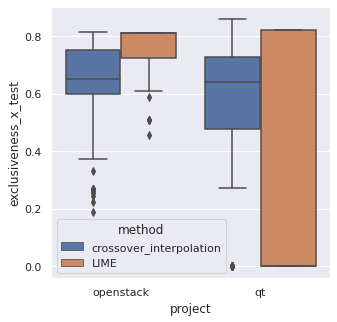

In [952]:
sns.boxplot(data=result_df, x='project', y='exclusiveness_x_test', hue='method')
plt.show()


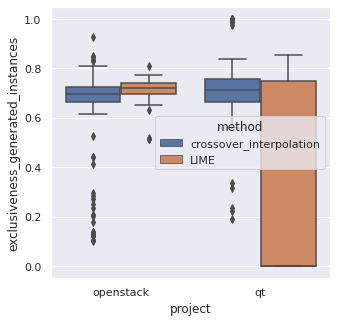

In [953]:
sns.boxplot(data=result_df, x='project', y='exclusiveness_generated_instances', hue='method')
plt.show()

In [ ]:
# note: defective commit is correctly predicted as defective commit
def predict_defective_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_pred = py_exp_local_model.predict(X_explain.values)
        
        lime_feature = np.ones((1,len(selected_feature_indices)))
        lime_prob = lime_exp_local_model.predict(lime_feature)
        lime_pred = np.round(lime_prob).astype(bool)
              
        if py_exp_pred:
            py_exp_pred_count = py_exp_pred_count +1
        if lime_pred:
            lime_pred_count = lime_pred_count + 1
            
    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [ ]:
# note: defective commit is correctly predicted as defective commit
def predict_defective_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
#         total_cond_in_py_exp = len(py_exp_the_best_defective_rule_str.split('&'))
#         lime_exp_condition_list = lime_exp['rule'].as_list()

#         lime_exp_condition_list.sort(key=operator.itemgetter(1), reverse=True)

#         top_k_lime_condition = [lime_exp_condition_list[i][0] for i in range(0,total_cond_in_py_exp)]
#         lime_the_best_defective_rule_str = ' & '.join(top_k_lime_condition)
        
#         print(lime_the_best_defective_rule_str)
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

#         print(py_exp_pred, lime_pred)
        
        if py_exp_pred == 1:
            py_exp_pred_count = py_exp_pred_count +1
        if lime_pred == 1:
            lime_pred_count = lime_pred_count + 1
            
#         break
        
    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [ ]:
def get_median_local_feature_rank(sorted_global_feature, rule):
    var_in_rule = list(set(re.findall('[a-zA-Z]+', rule)))
    var_rank = [sorted_global_feature.index(var)+1 for var in var_in_rule]
    return np.median(var_rank)

def get_local_feature_rank(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    eval_result = pd.DataFrame()
    
    sorted_global_feature = sort_global_feature(global_model, indep)
#     print(sorted_global_feature)
    
#     py_exp_med_rank = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_med_rank = get_median_local_feature_rank(sorted_global_feature, py_exp_the_best_defective_rule_str)
        lime_med_rank = get_median_local_feature_rank(sorted_global_feature, lime_the_best_defective_rule_str)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_med_rank])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_med_rank])
        
        eval_result = eval_result.append(py_exp_serie,ignore_index=True)
        eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
#         py_exp_var_in_rule = list(set(re.findall('[a-zA-Z]+', py_exp_the_best_defective_rule_str)))
#         lime_var_in_rule = list(set(re.findall('[a-zA-Z]+', lime_the_best_defective_rule_str)))

#         print(py_exp_the_best_defective_rule_str)
#         print(py_exp_var_in_rule)
        
#         print(lime_the_best_defective_rule_str)
#         print(lime_var_in_rule)
        
#         py_exp_var_rank = [sorted_global_feature.index(var)+1 for var in py_exp_var_in_rule]
#         lime_var_rank = [sorted_global_feature.index(var)+1 for var in lime_var_in_rule]
        
#         print(py_exp_var_rank, lime_var_rank)
#         break

    eval_result.columns = ['project', 'commit id', 'method', 'median_local_feature_rank']
    eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_median_local_feature_rank_20_rules.csv',index=False)
    
    print('finished',proj_name)
    
    
# def check_r2_score(proj_name):
#     global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
#     x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
#     eval_result = pd.DataFrame()
    
# #     print(sorted_global_feature)
    
# #     py_exp_med_rank = []
    
#     for i in range(0,len(feature_df)):
#         X_explain = feature_df.iloc[[i]]

#         row_index = str(X_explain.index[0])

#         py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
#         lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

#         py_exp_local_model = py_exp['local_model']
#         lime_exp_local_model = lime_exp['local_model']
        
#         # this data can be used for both local and global model
#         py_exp_synthetic_data = py_exp['synthetic_data'].values
#         # this data can be used with global model only
#         lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model']
#         # this data can be used with local model only
#         lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']
        
#         py_exp_train_pred = global_model.predict(py_exp_synthetic_data).astype(int)
#         py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data).astype(int)
        
# #         print(py_exp_train_pred)
# #         print(py_exp_local_pred)
#         lime_train_prob = global_model.predict_proba(lime_exp_synthetic_data)[:,1]
#         lime_local_prob = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        
#         py_exp_r2_score = r2_score(py_exp_train_pred, py_exp_local_pred)
#         lime_r2_score = r2_score(lime_train_prob, lime_local_prob)
        
#         py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_r2_score])
#         lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_r2_score])
        
#         eval_result = eval_result.append(py_exp_serie,ignore_index=True)
#         eval_result = eval_result.append(lime_exp_serie, ignore_index=True)
        
#     eval_result.columns = ['project', 'commit id', 'method', 'r2_score']
#     eval_result.to_csv(result_dir+'RQ3_555_'+proj_name+'_r2_score.csv',index=False)
    
#     print('finished',proj_name)
# #         print(py_exp_r2_score, lime_r2_score)
        
# #         break

In [765]:
# predict_defective_commit_by_local_model('openstack')
# predict_defective_commit_by_local_model('qt')
# print('-'*100)
# predict_defective_commit_by_rule('openstack')
# predict_defective_commit_by_rule('qt')

In [703]:
# print(f1_score([1,1,1,1],[0,1,0,1]))

In [971]:
def predict_test_defective_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    test_df = x_test.copy()
    test_df['label'] = list(y_test)
    test_df = test_df[test_df['label']==True]
    test_df = test_df.drop('label',axis=1)

    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred == 1: # and lime_pred == 1:
            py_exp_all_eval_result = eval_rule(py_exp_the_best_defective_rule_str, test_df)
            py_exp_percent_correct = np.sum(py_exp_all_eval_result)/len(test_df)
            py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_percent_correct])
            all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
            
#             py_exp_pred_count = py_exp_pred_count+1
            
        if lime_pred == 1:
            lime_all_eval_result = eval_rule(lime_the_best_defective_rule_str, test_df)
            lime_percent_correct = np.sum(lime_all_eval_result)/len(test_df)
            lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_percent_correct])
            all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'correctly_predict_ratio']

    all_eval_result.to_csv(result_dir+'RQ3_'+proj_name+'_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv',index=False)
#     print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [972]:
predict_test_defective_commit_by_rule('openstack')
predict_test_defective_commit_by_rule('qt')

0 0
finished RQ555 of openstack
0 0
finished RQ555 of qt


,project,commit id,method,correctly_predict_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.605263
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.258514
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.258514
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.184211
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.404025


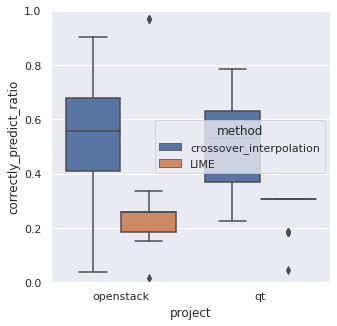

correctly_predict_ratio                      \
                                                    count      mean       std   
project   method                                                                
openstack LIME                                      198.0  0.234317  0.103856   
          crossover_interpolation                   138.0  0.541897  0.179807   
qt        LIME                                       38.0  0.274215  0.062921   
          crossover_interpolation                    39.0  0.506141  0.156524   

                                                                           \
                                        min       25%       50%       75%   
project   method                                                            
openstack LIME                     0.017028  0.184211  0.258514  0.258514   
          crossover_interpolation  0.037152  0.410991  0.556502  0.678793   
qt        LIME                     0.046218  0.306723  0.306723  0.306723   
          crossover_interpolation  0.226891  0.368697  0.529412  0.629202   

                                             
                                        max  
project   method                             
openstack LIME                     0.969040  
          crossover_interpolation  0.900929  
qt        LIME                     0.306723  
          crossover_interpolation  0.783613

In [973]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_openstack_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_qt_test_defective_commit_prediction_by_rule_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

plt.ylim(0,1)

sns.set(rc={'figure.figsize':(5,5)})

sns.boxplot(data=result_df, x='project', y='correctly_predict_ratio', hue='method')
plt.show()

display(result_df.groupby(['project','method']).describe())

In [706]:
# check_r2_score('openstack')
# check_r2_score('qt')

In [707]:
# openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_r2_score.csv')
# qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_r2_score.csv')

# result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head())

# plt.ylim(-1,1)
# sns.boxplot(data=result_df, x='project', y='r2_score', hue='method')
# plt.show()

In [855]:
# get_local_feature_rank('openstack')
# get_local_feature_rank('qt')

In [856]:
# openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_median_local_feature_rank_20_rules.csv')
# qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_median_local_feature_rank_20_rules.csv')

# result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head())

# sns.boxplot(data=result_df, x='project', y='median_local_feature_rank', hue='method')
# plt.show()

In [974]:
def predict_test_commit_by_rule(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_test, y_test = prepare_data(proj_name, mode = 'test')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']

        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit_new_version(py_exp_local_model)
        lime_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]
        
        py_exp_pred = eval_rule(py_exp_the_best_defective_rule_str, X_explain)[0]
        lime_pred = eval_rule(lime_the_best_defective_rule_str, X_explain)[0]

        if py_exp_pred == 1:
            py_exp_all_eval_result = eval_rule(py_exp_the_best_defective_rule_str, x_test)
            py_exp_f1 = f1_score(y_test, py_exp_all_eval_result)
            py_exp_mcc = matthews_corrcoef(y_test, py_exp_all_eval_result)
            py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_all_eval_result)
            py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_f1, py_exp_mcc])
            all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
            
        if lime_pred == 1:
            lime_all_eval_result = eval_rule(lime_the_best_defective_rule_str, x_test)
            lime_f1 = f1_score(y_test, lime_all_eval_result)
            lime_mcc = matthews_corrcoef(y_test, lime_all_eval_result)
            lime_bal_acc = balanced_accuracy_score(y_test, lime_all_eval_result)
            lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                              lime_bal_acc, lime_f1, lime_mcc])
            all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv',index=False)

    print('finished RQ555 of',proj_name)
    

In [975]:
start = time.time()
print('openstack')
predict_test_commit_by_rule('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_rule('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.543210,0.283539,0.063982
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.556832,0.238238,0.147392
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.647445,0.411348,0.299248
...,...,...,...,...,...,...
331,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.599260,0.330040,0.253269
332,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.665311,0.430813,0.310821
333,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.599260,0.330040,0.253269
334,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.666530,0.381022,0.246310


finished RQ555 of openstack
finished in 218.30340051651 secs
qt


,project,commit id,method,balanced_accuracy,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.662335,0.176655,0.153908
1,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.506967,0.108364,0.007146
2,qt,3168c94577cc604fd033ce4e741da5c411f74666,crossover_interpolation,0.629689,0.263333,0.213738
3,qt,23bdca417bde716c79168ab372083fd885607123,LIME,0.619712,0.254577,0.204224
4,qt,438211ec627073817fcaf6d3a07b76f2aa5d90e0,crossover_interpolation,0.582614,0.141216,0.079513
...,...,...,...,...,...,...
72,qt,2b67b50af18bb2a17ff10d5a37abfd85fc7e9d01,LIME,0.619712,0.254577,0.204224
73,qt,5f0023a7469e01bada70fbe677b76bb535eaa953,crossover_interpolation,0.651077,0.199765,0.162253
74,qt,5f0023a7469e01bada70fbe677b76bb535eaa953,LIME,0.424766,0.055346,-0.074692
75,qt,7c737e0edcb93585856c65890ef34e5c5a28ee6b,crossover_interpolation,0.651462,0.200236,0.162823


finished RQ555 of qt
finished in 108.34721422195435 secs


,project,commit id,method,balanced_accuracy,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.543210,0.283539,0.063982
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.599260,0.330040,0.253269
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.599260,0.330040,0.253269
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,0.556832,0.238238,0.147392
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,0.647445,0.411348,0.299248


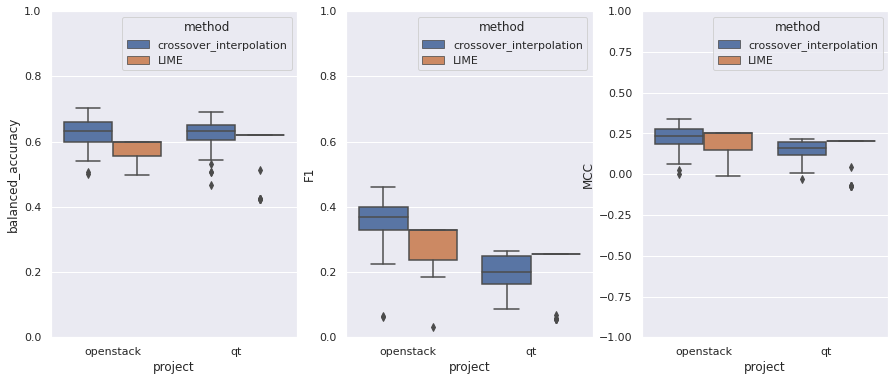

balanced_accuracy                      \
                                              count      mean       std   
project   method                                                          
openstack LIME                                198.0  0.575099  0.027960   
          crossover_interpolation             138.0  0.627763  0.043571   
qt        LIME                                 38.0  0.575862  0.080933   
          crossover_interpolation              39.0  0.620744  0.052139   

                                                                           \
                                        min       25%       50%       max   
project   method                                                            
openstack LIME                     0.498414  0.556832  0.599260  0.599260   
          crossover_interpolation  0.499774  0.599371  0.633216  0.701666   
qt        LIME                     0.424766  0.619712  0.619712  0.619712   
          crossover_interpolation  0.466911  0.605303  0.633924  0.691901   

                                      F1                                \
                                   count      mean       std       min   
project   method                                                         
openstack LIME                     198.0  0.280574  0.058066  0.030387   
          crossover_interpolation  138.0  0.359781  0.060701  0.063492   
qt        LIME                      38.0  0.207699  0.085297  0.055346   
          crossover_interpolation   39.0  0.195911  0.051346  0.085328   

                                                                   MCC  \
                                        25%       50%       max  count   
project   method                                                         
openstack LIME                     0.238238  0.330040  0.330040  198.0   
          crossover_interpolation  0.328474  0.369233  0.461078  138.0   
qt        LIME                     0.254577  0.254577  0.254577   38.0   
          crossover_interpolation  0.162439  0.200236  0.263333   39.0   

                                                                           \
                                       mean       std       min       25%   
project   method                                                            
openstack LIME                     0.189634  0.070802 -0.008433  0.147392   
          crossover_interpolation  0.219612  0.073537 -0.000845  0.183079   
qt        LIME                     0.141221  0.116017 -0.074692  0.204224   
          crossover_interpolation  0.147464  0.066099 -0.031363  0.119416   

                                                       
                                        50%       max  
project   method                                       
openstack LIME                     0.253269  0.253269  
          crossover_interpolation  0.234979  0.340331  
qt        LIME                     0.204224  0.204224  
          crossover_interpolation  0.163794  0.216112

In [978]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_rule_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(1,3, figsize=(15,6))

axs[0].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0])

axs[1].set_ylim([0, 1]) 
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1])

axs[2].set_ylim([-1, 1]) 
sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[2])

plt.show()
display(result_df.groupby(['project','method']).describe(percentiles=[.25,.5]))

In [ ]:
## use local model to predict test instance
def predict_test_commit_by_local_model(proj_name):
    global_model, correctly_predict_df, indep, dep, feature_df = prepare_data_for_testing(proj_name)
    x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
    
    categorical_features_list = [6]
    class_label = ['clean', 'defect']
    
    lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=categorical_features_list, 
                                      feature_names=indep, class_names=class_label, discretizer = 'decile',
                                      random_state=0)
    
    all_eval_result = pd.DataFrame()
    
    py_exp_pred_count = 0
    lime_pred_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'_20_rules.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']
        selected_feature_indices = lime_exp['selected_feature_indeces']
        
        py_exp_prob = py_exp_local_model.predict_proba(x_test.values)[:,1]
        py_exp_pred = py_exp_local_model.predict(x_test.values)
        
        lime_discretized_sample = lime_explainer.discretizer.discretize(X_explain.values)
        discretized_x_test = lime_explainer.discretizer.discretize(x_test.values)
        compare_discretized_val = (lime_discretized_sample==discretized_x_test).astype(int)
        compare_discretized_val = (compare_discretized_val - lime_explainer.scaler.mean_) / lime_explainer.scaler.scale_
        compare_discretized_val = compare_discretized_val[:,selected_feature_indices]
        lime_prob = lime_exp_local_model.predict(compare_discretized_val)
        lime_pred = np.round(lime_prob).astype(bool)
#         print(lime_pred)

        py_exp_auc = roc_auc_score(y_test, py_exp_prob)
        py_exp_f1 = f1_score(y_test, py_exp_pred)
        py_exp_mcc = matthews_corrcoef(y_test, py_exp_pred)
        py_exp_bal_acc = balanced_accuracy_score(y_test, py_exp_pred)
        
        lime_auc = roc_auc_score(y_test, lime_prob)
        lime_f1 = f1_score(y_test, lime_pred)
        lime_mcc = matthews_corrcoef(y_test, lime_pred)
        lime_bal_acc = balanced_accuracy_score(y_test, lime_pred)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',
                                       py_exp_bal_acc, py_exp_auc, py_exp_f1, py_exp_mcc])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME',
                                          lime_bal_acc, lime_auc, lime_f1, lime_mcc])
        
        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

    all_eval_result.columns = ['project', 'commit id', 'method', 'balanced_accuracy', 'AUC', 'F1','MCC']
    
    display(all_eval_result)
    all_eval_result.to_csv(result_dir+'RQ555_'+proj_name+'_test_commit_prediction_by_local_model_lime_decile_20_rules.csv',index=False)

    print(py_exp_pred_count, lime_pred_count)
    print('finished RQ555 of',proj_name)

In [713]:
start = time.time()
print('openstack')
predict_test_commit_by_local_model('openstack')
end = time.time()
print('finished in',str(end-start), 'secs')

start = time.time()
print('qt')
predict_test_commit_by_local_model('qt')
end = time.time()
print('finished in',str(end-start), 'secs')

openstack


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.617947,0.684904,0.352800,0.199622
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.514787,0.605924,0.066763,0.105445
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.666248,0.701339,0.410169,0.272464
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543697,0.637545,0.173456,0.192313
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.659263,0.709934,0.375369,0.235524
...,...,...,...,...,...,...,...
391,openstack,605749ca12af969ac122008b4fa14904df68caf7,LIME,0.527493,0.654035,0.112835,0.162381
392,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,crossover_interpolation,0.564755,0.667203,0.259643,0.155903
393,openstack,85239cc81440d9e5a4aee3c0961c96a4197ad939,LIME,0.526438,0.632401,0.111732,0.148269
394,openstack,f0f52a0085a1f5bbd23e6cfa8f0ea935e8fd56c8,crossover_interpolation,0.633016,0.672643,0.364268,0.206650


0 0
finished RQ555 of openstack
finished in 3.422733783721924 secs
qt


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalar

,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,crossover_interpolation,0.647752,0.709811,0.214353,0.172518
1,qt,f5dbc876378ae58a7bdfe1e9664fc81caca18dfb,LIME,0.501050,0.598034,0.004193,0.044500
2,qt,602bd9873786ccadcb67da3036329f3122555cf8,crossover_interpolation,0.625379,0.680174,0.168553,0.124476
3,qt,602bd9873786ccadcb67da3036329f3122555cf8,LIME,0.500000,0.545652,0.000000,0.000000
4,qt,9d75626b1073113d77988bcb52e99215d5af4787,crossover_interpolation,0.545003,0.601962,0.119353,0.044471
...,...,...,...,...,...,...,...
153,qt,9bb634a6176c639bd6b52d58151e9927c30919d0,LIME,0.501050,0.492555,0.004193,0.044500
154,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,crossover_interpolation,0.622744,0.688596,0.182410,0.133971
155,qt,1e8de50674f5b33a50c45224b7e07b3f974f6ab0,LIME,0.501050,0.593483,0.004193,0.044500
156,qt,979a0406f0013560efbdcc486b32ba93ce8c946f,crossover_interpolation,0.648460,0.709573,0.195011,0.157172


0 0
finished RQ555 of qt
finished in 2.335747241973877 secs


,project,commit id,method,balanced_accuracy,AUC,F1,MCC
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,0.617947,0.684904,0.352800,0.199622
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,0.514787,0.605924,0.066763,0.105445
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,0.666248,0.701339,0.410169,0.272464
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,0.543697,0.637545,0.173456,0.192313
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,0.659263,0.709934,0.375369,0.235524


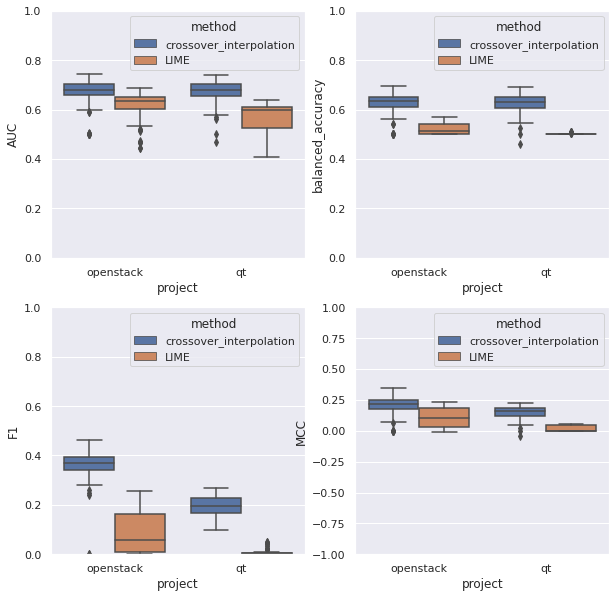

In [895]:
openstack_result_df = pd.read_csv('./eval_result/RQ555_openstack_test_commit_prediction_by_local_model_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ555_qt_test_commit_prediction_by_local_model_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head())

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].set(ylim=(0, 1))
axs[0,1].set(ylim=(0, 1))
axs[1,0].set(ylim=(0, 1))
axs[1,1].set(ylim=(-1, 1))

sns.boxplot(data=result_df, x='project', y='AUC', hue='method', ax=axs[0,0])
sns.boxplot(data=result_df, x='project', y='balanced_accuracy', hue='method', ax=axs[0,1])
sns.boxplot(data=result_df, x='project', y='F1', hue='method', ax=axs[1,0])

sns.boxplot(data=result_df, x='project', y='MCC', hue='method', ax=axs[1,1])

plt.show()

openstack
finished 1 from 198 commits
finished 2 from 198 commits
finished 3 from 198 commits
finished 4 from 198 commits
finished 5 from 198 commits
finished 6 from 198 commits
finished 7 from 198 commits
finished 8 from 198 commits
finished 9 from 198 commits
finished 10 from 198 commits
finished 11 from 198 commits
finished 12 from 198 commits
finished 13 from 198 commits
finished 14 from 198 commits
finished 15 from 198 commits
finished 16 from 198 commits
finished 17 from 198 commits
finished 18 from 198 commits
finished 19 from 198 commits
finished 20 from 198 commits
finished 21 from 198 commits
finished 22 from 198 commits
finished 23 from 198 commits
finished 24 from 198 commits
finished 25 from 198 commits
finished 26 from 198 commits
finished 27 from 198 commits
finished 28 from 198 commits
finished 29 from 198 commits
finished 30 from 198 commits
finished 31 from 198 commits
finished 32 from 198 commits
finished 33 from 198 commits
finished 34 from 198 commits
finished 35 f

rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  92.483019   2.027977  75.000000   
          crossover_interpolation      198.0  86.384273  29.451546   0.000000   
qt        LIME                          79.0  93.686244   0.852829  90.854326   
          crossover_interpolation       79.0  70.121895  42.744182   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     91.969490  92.602913  93.031649   96.445498  
          crossover_interpolation  93.714503  96.946387  98.910973  100.000000  
qt        LIME                     93.346105  94.027618  94.396795   94.420926  
          crossover_interpolation   0.000000  96.144279  97.507483  100.000000

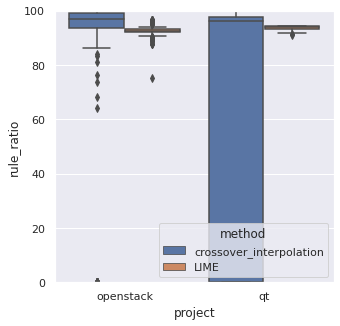

In [891]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
# display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.309883
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,91.950018
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,91.950018
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,90.744298
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,94.690265
5,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,90.744298
6,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,91.950018
7,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,crossover_interpolation,100.000000
8,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,LIME,91.950018
9,openstack,8db51da1e25f1c148fbe8d8f27d144a39d1850f3,crossover_interpolation,98.148148


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  91.253228   0.760854  89.389245   
          crossover_interpolation      138.0  88.200678  28.638557   0.000000   
qt        LIME                          38.0  93.440730   1.069584  91.503409   
          crossover_interpolation       39.0  84.670515  32.938067   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     90.744298  91.950018  91.950018   91.950018  
          crossover_interpolation  94.742189  97.391107  99.565644  100.000000  
qt        LIME                     94.027618  94.027618  94.027618   94.027618  
          crossover_interpolation  95.695977  96.645367  98.282784  100.000000

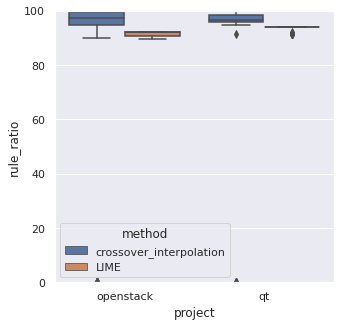

In [882]:
openstack_result_df = pd.read_csv('./eval_result/RQ3_555_openstack_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ3_555_qt_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.000000
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,87.343702
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,97.732997
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,88.146482
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,80.516432
5,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,85.401662
6,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,86.666667
7,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,91.477273
8,openstack,96677735f6d8f1f5b6380127956921f719aab799,crossover_interpolation,0.000000
9,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,88.730929


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  90.274851   3.170842  84.613229   
          crossover_interpolation      198.0  82.980207  30.230322   0.000000   
qt        LIME                          79.0  95.426392   0.766852  93.037861   
          crossover_interpolation       79.0  71.452577  43.431308   0.000000   

                                                                                
                                         25%        50%        75%         max  
project   method                                                                
openstack LIME                     88.146482  88.923720  92.771084  100.000000  
          crossover_interpolation  87.686758  94.297329  98.075397  100.000000  
qt        LIME                     94.854693  95.661320  95.960179   98.421808  
          crossover_interpolation   0.000000  98.148148  98.984745  100.000000

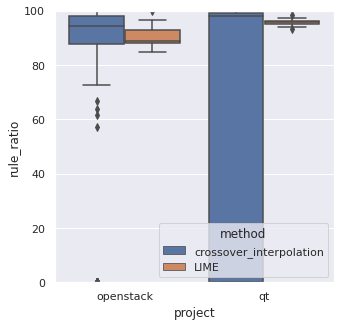

In [892]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_555_openstack_lime_decile_20_rules.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_555_qt_lime_decile_20_rules.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

,project,commit id,method,rule_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,95.000000
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,86.683347
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,86.683347
3,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,LIME,85.401662
4,openstack,957533f685caf9ffc0d9cad569598455d59ade34,crossover_interpolation,86.666667
5,openstack,957533f685caf9ffc0d9cad569598455d59ade34,LIME,85.401662
6,openstack,96677735f6d8f1f5b6380127956921f719aab799,LIME,86.683347
7,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,crossover_interpolation,100.000000
8,openstack,10593c2eaf4eff4edb13b70f023acbbf743f129f,LIME,86.683347
9,openstack,8db51da1e25f1c148fbe8d8f27d144a39d1850f3,crossover_interpolation,89.285714


rule_ratio                                   \
                                       count       mean        std        min   
project   method                                                                
openstack LIME                         198.0  86.071260   1.021572  83.655084   
          crossover_interpolation      138.0  84.656934  30.026178   0.000000   
qt        LIME                          38.0  95.075636   1.085954  93.037861   
          crossover_interpolation       39.0  85.510896  33.344035   0.000000   

                                                                     \
                                         25%        50%         75%   
project   method                                                      
openstack LIME                     85.401662  86.683347   86.683347   
          crossover_interpolation  89.741379  94.982639  100.000000   
qt        LIME                     95.661320  95.661320   95.661320   
          crossover_interpolation  97.371559  98.442368   99.276609   

                                               
                                          max  
project   method                               
openstack LIME                      90.990991  
          crossover_interpolation  100.000000  
qt        LIME                      95.661320  
          crossover_interpolation  100.000000

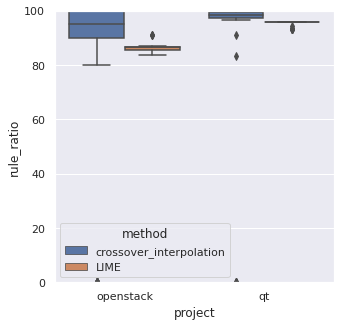

In [883]:
openstack_result_df = pd.read_csv('./eval_result/RQ4_openstack_lime_decile_20_rules_new.csv')
qt_result_df = pd.read_csv('./eval_result/RQ4_qt_lime_decile_20_rules_new.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
display(result_df.head(10))

plt.ylim(0,100)
sns.boxplot(data=result_df, x='project', y='rule_ratio', hue='method')

display(result_df.groupby(['project','method']).describe())

finished RQ1 of openstack
finished RQ1 of qt


,project,commit id,method,euc_dist_med,defective_generated_instance_ratio
0,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,crossover_interpolation,354.738406,0.406250
1,openstack,1e6973aee7137653c62dcef970b1e2527b50517d,LIME,479.405778,0.003600
2,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,crossover_interpolation,494.990758,0.770257
3,openstack,5d0ccceb20780fdd3adf519d3f8e6b80b1844407,LIME,1322.151611,0.008600
4,openstack,de31210c05f464c4a79255de68b1a515d9b84ed3,crossover_interpolation,232.856076,0.566071


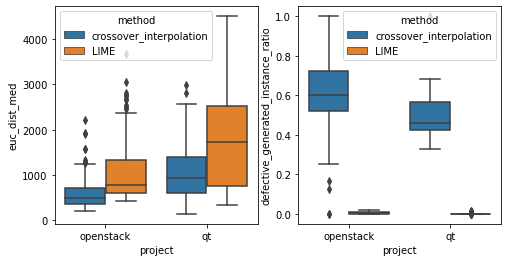

openstack result


euc_dist_med                                       \
                               count         mean         std         min   
method                                                                      
LIME                           198.0  1061.468282  633.440499  418.108698   
crossover_interpolation        198.0   592.369333  336.972263  211.235688   

                                                                           \
                                25%         50%          75%          max   
method                                                                      
LIME                     602.797922  788.432944  1337.689842  3679.497205   
crossover_interpolation  360.263004  494.947457   717.450402  2219.862411   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                 198.0  0.004772   
crossover_interpolation                              198.0  0.610123   

                                                                              
                              std  min       25%       50%       75%     max  
method                                                                        
LIME                     0.004454  0.0  0.000600  0.004000  0.008550  0.0178  
crossover_interpolation  0.152132  0.0  0.519085  0.603223  0.724593  1.0000

qt result


euc_dist_med                                        \
                               count         mean          std         min   
method                                                                       
LIME                            79.0  1782.554741  1104.872167  328.933327   
crossover_interpolation         79.0  1075.365549   664.703661  140.597045   

                                                                            \
                                25%          50%          75%          max   
method                                                                       
LIME                     767.305166  1723.787418  2524.461375  4505.040648   
crossover_interpolation  599.290091   931.887346  1390.417825  2980.305885   

                        defective_generated_instance_ratio            \
                                                     count      mean   
method                                                                 
LIME                                                  79.0  0.001344   
crossover_interpolation                               79.0  0.494272   

                                                                         \
                              std       min       25%     50%       75%   
method                                                                    
LIME                     0.003419  0.000000  0.000000  0.0002  0.000200   
crossover_interpolation  0.104604  0.329301  0.423437  0.4614  0.566768   

                                 
                            max  
method                           
LIME                     0.0138  
crossover_interpolation  1.0000